# Tumoroscope in PyMC

## Setup

In [1]:
from dataclasses import dataclass
from pathlib import Path

import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Arviz config.
az.rcparams.rcParams["stats.hdi_prob"] = 0.89

# Models directory.
models_dir = Path("models")
if not models_dir.exists():
    models_dir.mkdir()

## Introduction

![tumoroscope overview](tumoroscope-overview.png)

## Model

In [4]:
@dataclass
class TumoroscopeData:
    """Tumoroscope model data."""

    K: int  # number of clones
    S: int  # number of spots
    P: int  # number of mutation positions
    F: np.ndarray  # Prevelance of clones from bulk-DNA seq.
    Lambda: np.ndarray  # Number of cell counted per spot
    C: np.ndarray  # Zygosity per position and clone
    D_obs: np.ndarray | None  # Read count per position per spot
    A_obs: np.ndarray | None  # Alternated reads per position per spot
    zeta_s: float = 1  # Pi hyper-parameter
    F_0: float = 0.01  # "pseudo-frequency" for lower bound on clone proportion
    l: float = 100  # Scaling factor to discretize F
    r: float = 0.09  # shape parameter for Gamma over Phi
    p: float = 1  # rate parameter for Gamma over Phi


def _prefixed_index(n: int, prefix: str) -> list[str]:
    return [f"{prefix}{i}" for i in np.arange(n)]


def _check_tumoroscope_data(data: TumoroscopeData) -> None:
    assert data.F.sum() == 1.0
    assert data.F.ndim == 1
    assert data.F.shape[0] == data.K


def _make_tumoroscope_model_coords(data: TumoroscopeData) -> dict[str, list[str]]:
    coords = {
        "clone": _prefixed_index(data.K, "c"),
        "spot": _prefixed_index(data.S, "s"),
        "position": _prefixed_index(data.P, "p"),
    }
    return coords


def tumoroscope(data: TumoroscopeData) -> pm.Model:
    _check_tumoroscope_data(data)
    coords = _make_tumoroscope_model_coords(data)
    _Z_init = np.ones((data.S, data.K), dtype=int)
    with pm.Model(coords=coords) as model:
        ζ_s = pm.ConstantData("ζ_s", data.zeta_s)
        ℓ = pm.ConstantData("ℓ", data.l)
        F_0 = pm.ConstantData("F0", data.F_0)
        F = pm.ConstantData("F", data.F, dims="clone")
        Λ = pm.ConstantData("Λ", data.Lambda, dims="spot")
        r = pm.ConstantData("r", data.r)
        p = pm.ConstantData("p", data.p)
        C = pm.ConstantData("C", data.C, dims=("position", "clone"))

        F_prime = pm.Deterministic("F_prime", ℓ * 20 * F / 20, dims="clone")

        Π = pm.Beta("Π", alpha=ζ_s, beta=1, dims=("spot", "clone"))
        Z = pm.Bernoulli("Z", p=Π, dims=("spot", "clone"))  # , initval=_Z_init)
        G = pm.Gamma("G", (F_prime**Z) * (F_0 ** (1 - Z)), 1, dims=("spot", "clone"))
        H = pm.Deterministic("H", G / G.sum(axis=1)[:, None], dims=("spot", "clone"))

        N = pm.Poisson("N", Λ, dims="spot")
        Φ = pm.Gamma("Φ", r, p, dims=("position", "clone"))
        D = pm.Poisson(
            "D", N * H.dot(Φ.T).T, dims=("position", "spot"), observed=data.D_obs
        )

        _A_num = pm.Deterministic(
            "A_num", H[:, 1:].dot((Φ[:, 1:] * C[:, 1:]).T).T, dims=("position", "spot")
        )
        _A_denom = pm.Deterministic(
            "A_denom", H[:, 1:].dot(Φ[:, 1:].T).T, dims=("position", "spot")
        )
        A = pm.Binomial(
            "A", D, _A_num / _A_denom, dims=("position", "spot"), observed=data.A_obs
        )
    return model

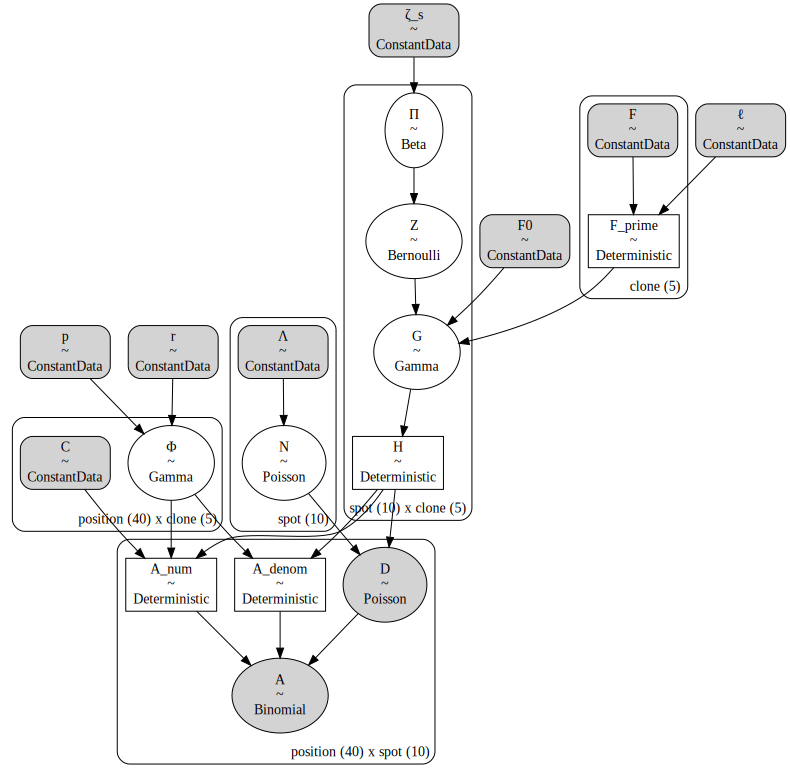

In [5]:
np.random.seed(234)
mock_tumor_data = TumoroscopeData(
    K=5,
    S=10,
    P=40,
    F=np.ones(5) / 5.0,
    Lambda=np.random.randint(1, 20, size=10),
    C=np.random.beta(2, 2, size=(40, 5)),
    D_obs=np.random.randint(2, 20, size=(40, 10)),
    A_obs=np.random.randint(2, 20, size=(40, 10)),
)

m = tumoroscope(mock_tumor_data)
pm.model_to_graphviz(m)

To-Do:

- generate mock data and test model
- try to use Dirichlet for $P(H|F^\prime,F_0,Z)$ like the Methods explains

Possible improvements

- explore prior distributions over the current user-supplied hyper-parameters
- utilize spatial relationships in the estimation of clonal distributions per spot

## Prior predictive sampling

In [6]:
example_input_data = TumoroscopeData(
    K=5,
    S=10,
    P=40,
    F=np.array([0.01, 0.05, 0.15, 0.3, 0.49]),
    Lambda=np.ones(10) * 5,
    C=np.ones((40, 5), float),
    D_obs=None,
    A_obs=None,
    r=0.19,
    p=1,
)

with tumoroscope(example_input_data) as m:
    prior_pred = pm.sample_prior_predictive(
        500,
        var_names=["D", "A", "H", "G", "Z", "Π", "Φ", "N", "A_num", "A_denom"],
        random_seed=123,
    )

Sampling: [A, D, G, N, Z, Π, Φ]


In [7]:
prior_pred.constant_data["Λ"].values

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

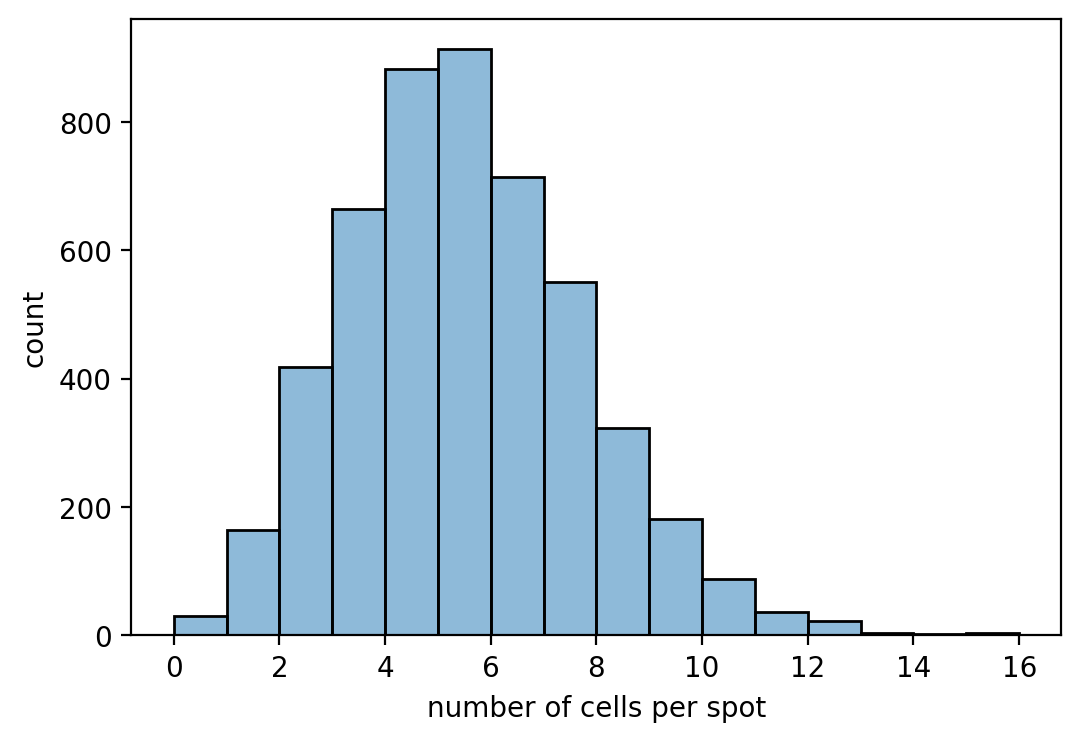

In [8]:
_, ax = plt.subplots(figsize=(6, 4))
sns.histplot(prior_pred.prior["N"].values.flatten(), alpha=0.5, binwidth=1, ax=ax)
ax.set_xlabel("number of cells per spot")
ax.set_ylabel("count")
plt.show()

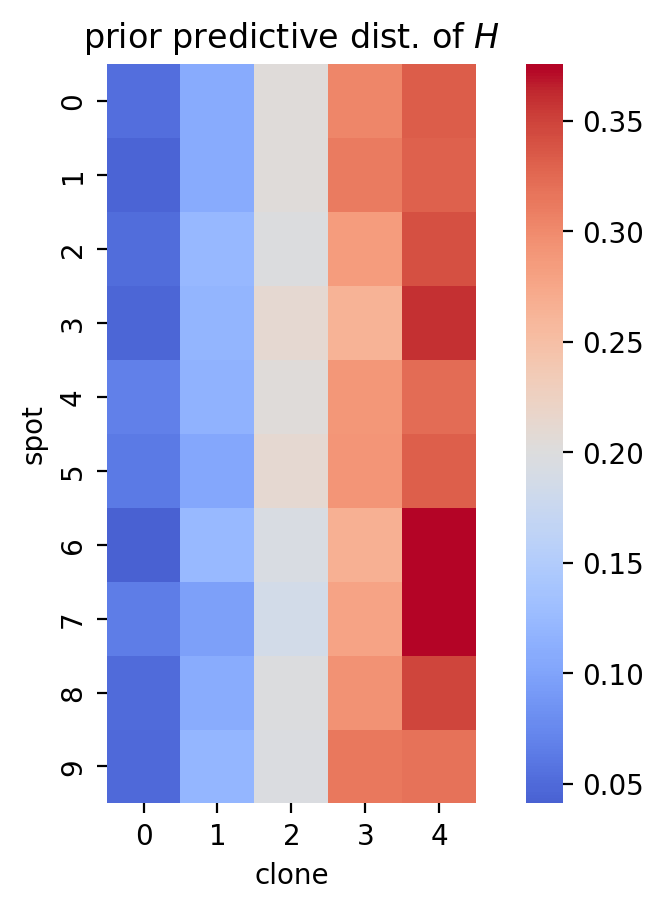

In [9]:
H_mean = prior_pred.prior["H"].values.squeeze().mean(axis=0)
ax = sns.heatmap(
    data=H_mean, cmap="coolwarm", center=1 / mock_tumor_data.K, square=True
)
ax.set_xlabel("clone")
ax.set_ylabel("spot")
ax.set_title("prior predictive dist. of $H$")
plt.show()

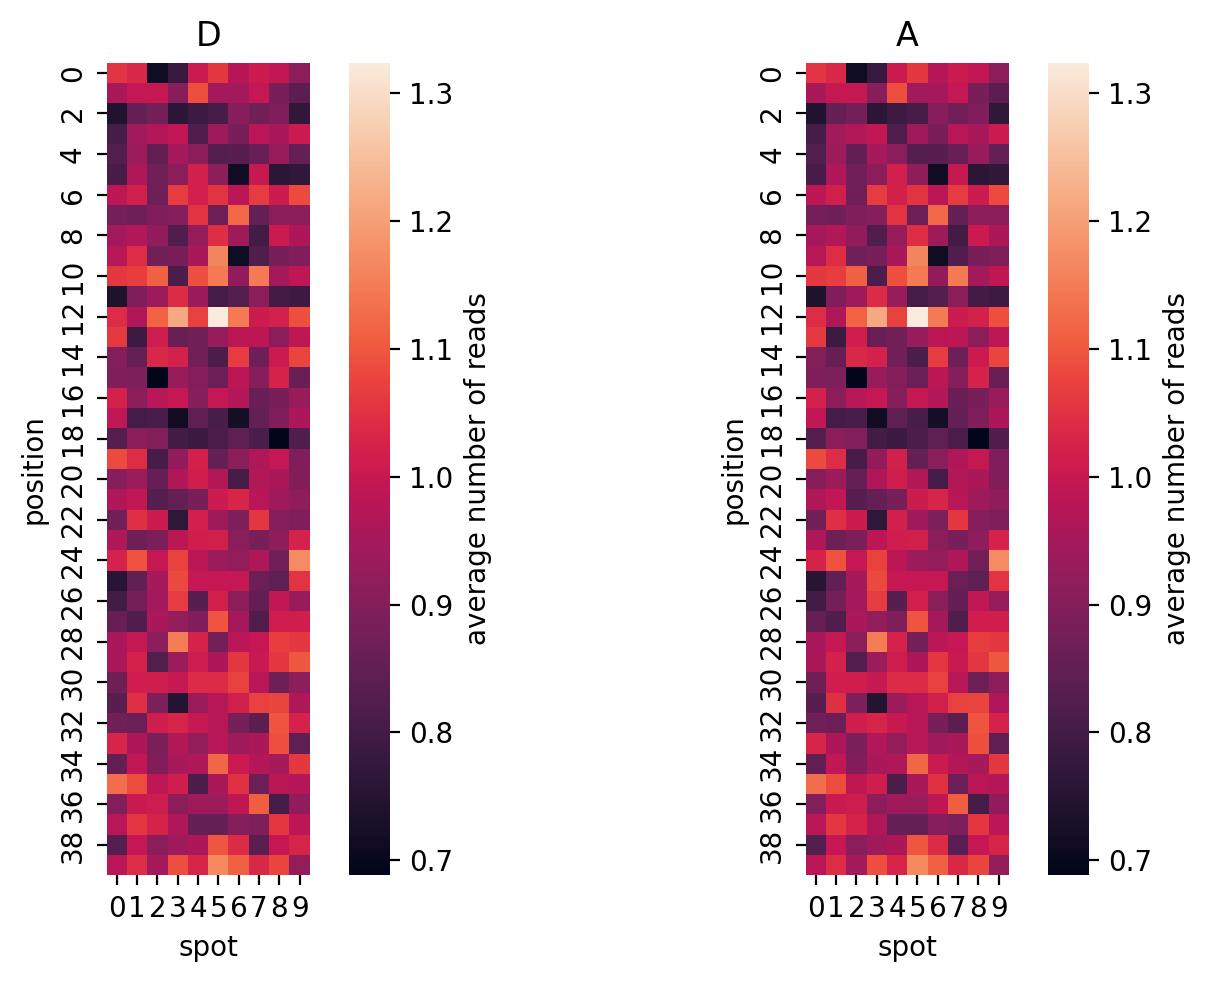

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
for ax, var_name in zip(axes, ["D", "A"]):
    var_prior_mean = prior_pred.prior[var_name].mean(axis=(0, 1)).values
    sns.heatmap(
        var_prior_mean,
        square=True,
        cbar_kws={"label": "average number of reads"},
        ax=ax,
    )
    ax.set_xlabel("spot")
    ax.set_ylabel("position")
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

Average number of reads *per spot*.

In [11]:
prior_pred.prior["D"].mean(axis=(0, 1)).sum(axis=0).values

array([36.912, 38.294, 36.97 , 37.696, 37.998, 38.878, 37.838, 37.492,
       37.948, 38.102])

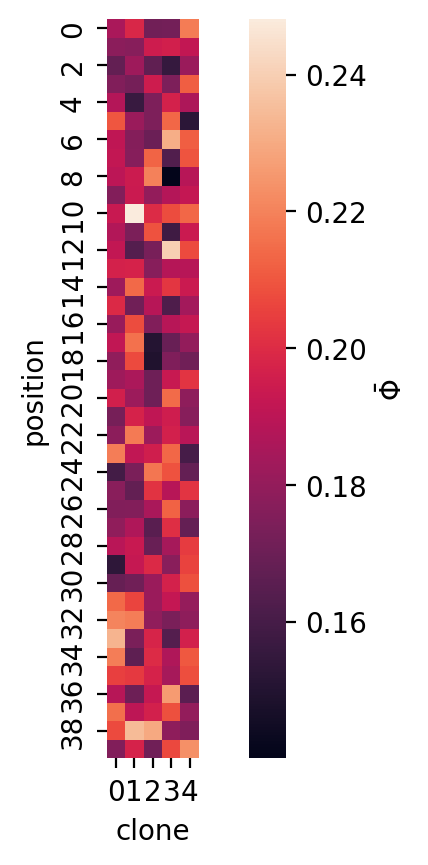

In [12]:
phi_prior_mean = prior_pred.prior["Φ"].mean(axis=(0, 1)).values
ax = sns.heatmap(phi_prior_mean, square=True, cbar_kws={"label": r"$\bar{\Phi}$"})
ax.set_xlabel("clone")
ax.set_ylabel("position")
plt.show()

## Simulation experiments

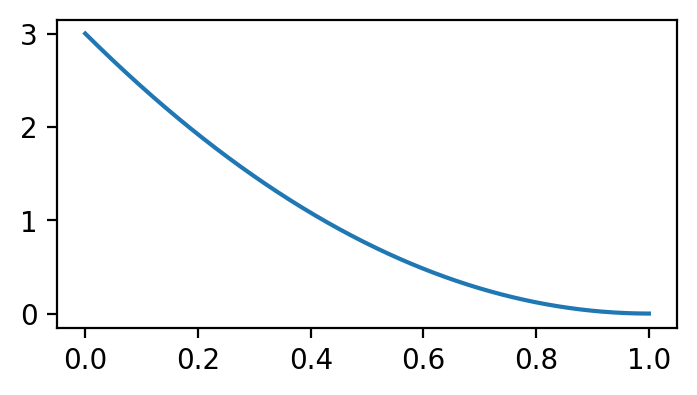

In [13]:
_, ax = plt.subplots(figsize=(4, 2))
x = np.linspace(0, 1, 500)
y = scipy.stats.beta(1, 3).pdf(x)
ax.plot(x, y)
plt.show()

In [14]:
# Set seed for reproducible results.
np.random.seed(8383)

# Set true underlying constants.
N_CLONES = 2
N_SPOTS = 20
n_positions = 300  # changes below

# Number of cells counted in each spot between 2 and 8 cells.
cell_counts = np.random.randint(2, 8, size=N_SPOTS)

# True mutations for each clone.
clone_mutations = np.hstack(
    [np.random.binomial(1, p, size=(n_positions, 1)) for p in [0.5, 0.5]]
)
# Drop positions without any mutations.
clone_mutations = clone_mutations[clone_mutations.sum(axis=1) > 0.0, :]
clone_mutations = clone_mutations[clone_mutations.mean(axis=1) < 1.0, :]
n_positions = clone_mutations.shape[0]
print(f"Number of positions: {n_positions}")

# Assign probability distribution over spots for each clone.
clone_props_params = [(3, 1), (1, 3)]
spots_x = np.linspace(0, 1, N_SPOTS)
clone_proportions = np.hstack(
    [scipy.stats.beta(a, b).pdf(spots_x)[:, None] for a, b in clone_props_params]
)
clone_proportions = clone_proportions / clone_proportions.sum(axis=1)[:, None]

# True fraction of clones taken from the underlying distributions.
F = np.array([a / (a + b) for a, b in clone_props_params])
F = F / F.sum()

_cell_labels: list[tuple[int, int, int]] = []
clones = np.arange(N_CLONES)
for spot_i in range(N_SPOTS):
    for cell_j in range(cell_counts[spot_i]):
        clone = np.random.choice(clones, size=1, p=clone_proportions[spot_i, :])[0]
        _cell_labels.append((spot_i, cell_j, clone))
cell_labels = pd.DataFrame(_cell_labels, columns=["spot", "cell", "clone"])
cell_labels.head()

Number of positions: 131


,spot,cell,clone
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,1,0,1


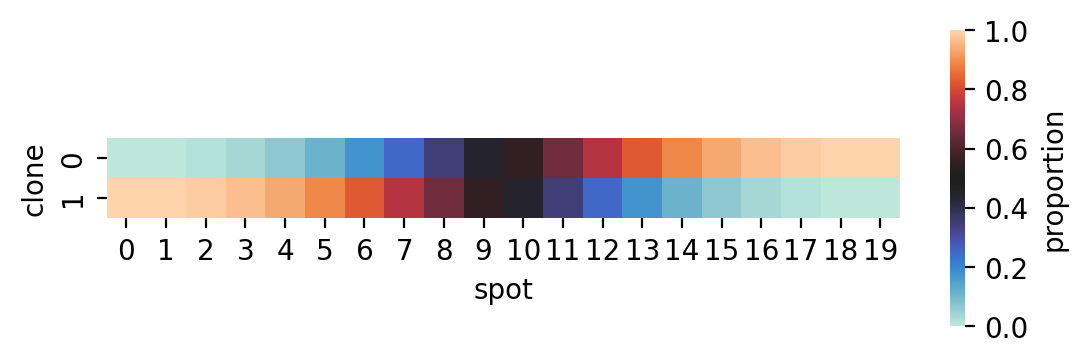

In [15]:
ax = sns.heatmap(
    clone_proportions.T,
    cmap="icefire",
    center=0.5,
    vmin=0,
    vmax=1.0,
    square=True,
    cbar_kws={"shrink": 0.4, "label": "proportion"},
)
ax.set_xlabel("spot")
ax.set_ylabel("clone")
plt.show()

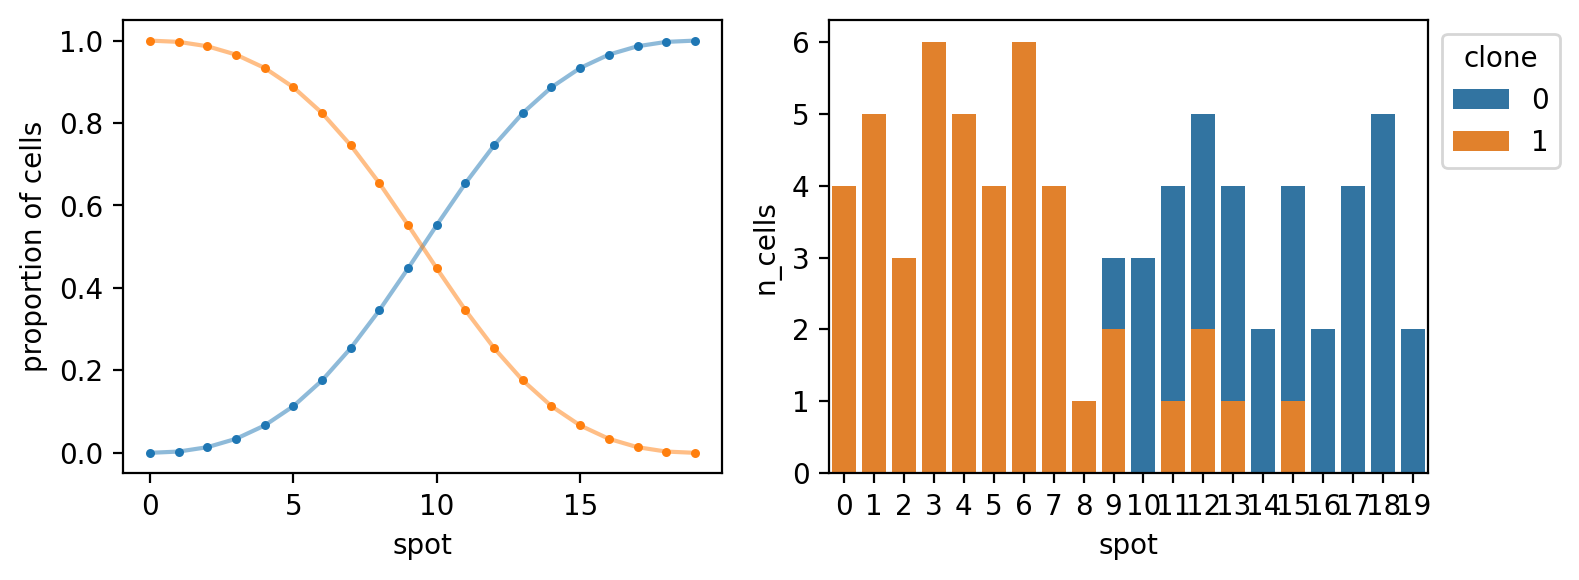

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))

ax = axes[0]
for i in range(clone_proportions.shape[1]):
    x = np.arange(clone_proportions.shape[0])
    ax.plot(x, clone_proportions[:, i], label=f"{i}", alpha=0.5)
    ax.scatter(x, clone_proportions[:, i], s=5)

ax.set_xlabel("spot")
ax.set_ylabel("proportion of cells")

ax = axes[1]
clones_per_spot = (
    cell_labels.groupby(["spot", "clone"])
    .count()
    .reset_index()
    .rename(columns={"cell": "n_cells"})
    .astype({"clone": "category"})
)

sns.barplot(
    data=clones_per_spot, x="spot", y="n_cells", hue="clone", ax=ax, dodge=False
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="clone")
fig.tight_layout()
plt.show()

Actual clone proportions vs. the randomly sampled clone proportions averaging across spots:

In [17]:
F, clone_proportions.mean(axis=0)

(array([0.75, 0.25]), array([0.5, 0.5]))

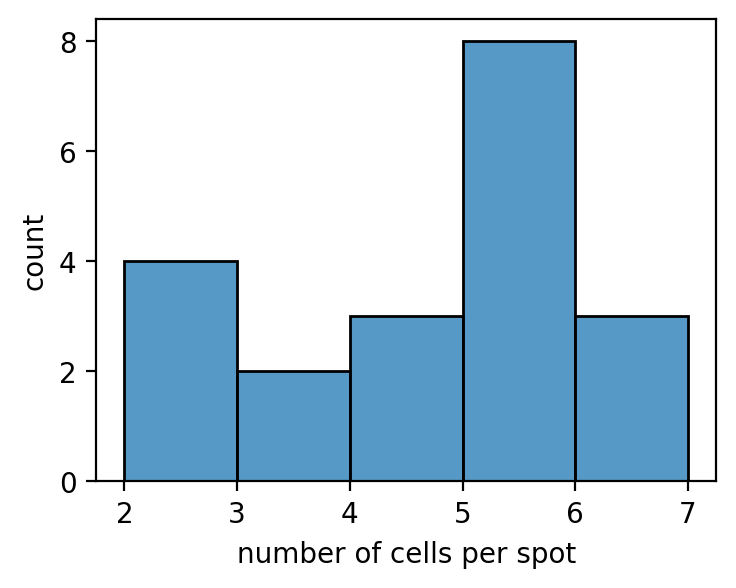

In [18]:
_, ax = plt.subplots(figsize=(4, 3))
sns.histplot(cell_counts.flatten(), binwidth=1, ax=ax)
ax.set_xlabel("number of cells per spot")
ax.set_ylabel("count")
plt.show()

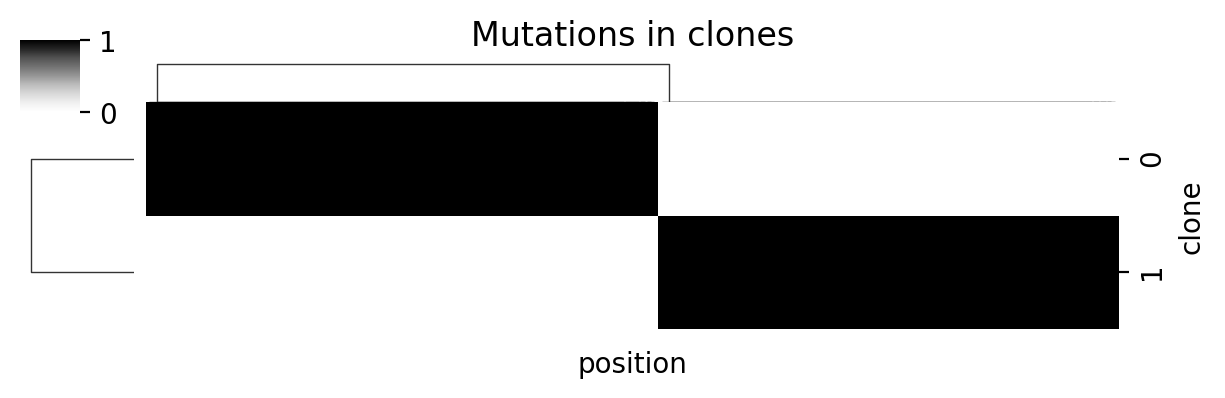

In [19]:
cg = sns.clustermap(
    clone_mutations.T, figsize=(6, 2), dendrogram_ratio=(0.1, 0.15), cmap="Greys"
)
cg.ax_heatmap.set_xlabel("position")
cg.ax_heatmap.set_ylabel("clone")
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.tick_params("x", size=0)
cg.ax_col_dendrogram.set_title("Mutations in clones")
plt.show()

In [20]:
clone_mutations.shape

(131, 2)

In [21]:
# Randomly assign read coverage per position per spot with min of 2 reads.
# read_coverage = np.random.poisson(10, size=(n_positions, N_SPOTS)) + 2

# Randomly assign zygosity per position for each clone.
# zygosity = np.random.beta(10, 1, size=(n_positions, N_CLONES))
zygosity = np.ones((n_positions, N_CLONES))
print(f"average zygosity: {zygosity.mean():0.2f}")

# For each cell in each spot, sample some number of reads for each position.
# Builds the matrix A for number of alternate reads per position and spot.
# alt_read_counts = (clone_mutations * zygosity).dot(clone_proportions.T) * read_coverage
alt_read_counts = np.zeros((n_positions, N_SPOTS, N_CLONES))
tot_read_counts = np.zeros((n_positions, N_SPOTS, N_CLONES))
for _, row in cell_labels.iterrows():
    alt_reads = (
        np.random.poisson(3, size=n_positions) * clone_mutations[:, row["clone"]]
    )
    alt_read_counts[:, row["spot"], row["clone"]] = alt_reads
    tot_reads = alt_reads + (1 - zygosity[:, row["clone"]]) * alt_reads
    tot_read_counts[:, row["spot"], row["clone"]] = tot_reads

alt_read_counts = alt_read_counts.sum(axis=2)
tot_read_counts = tot_read_counts.sum(axis=2)
alt_read_counts.shape

average zygosity: 1.00


(131, 20)

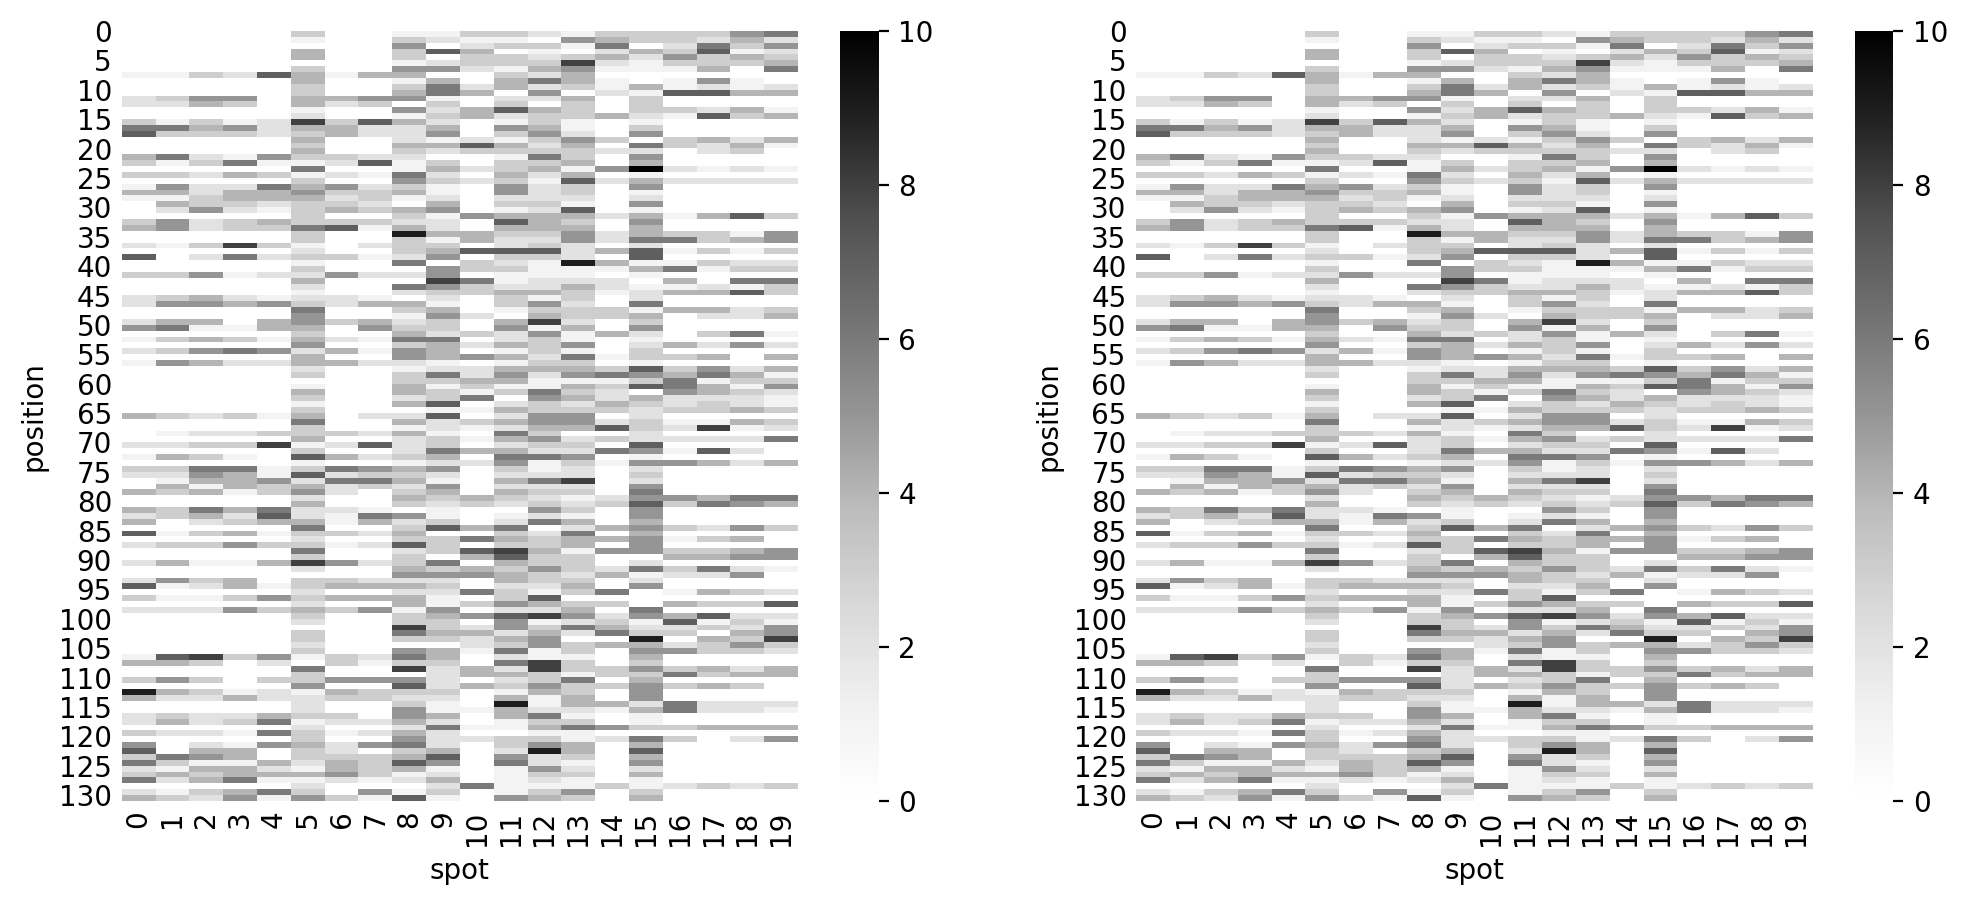

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(tot_read_counts, cmap="Greys", ax=axes[0])
ax.set_title("Total read counts")
sns.heatmap(alt_read_counts, cmap="Greys", ax=axes[1])
ax.set_title("Alternative read counts")

for ax in axes:
    ax.tick_params(size=0)
    ax.set_xlabel("spot")
    ax.set_ylabel("position")

plt.show()

Number of reads per spot.

In [23]:
tot_read_counts.sum(axis=0).round(2)

array([188., 182., 195., 194., 187., 398., 180., 177., 419., 389., 212.,
       407., 420., 397., 192., 432., 207., 230., 210., 211.])

In [24]:
sim_data = TumoroscopeData(
    K=N_CLONES,
    S=N_SPOTS,
    P=n_positions,
    F=F,
    Lambda=cell_counts,
    C=zygosity,
    D_obs=tot_read_counts,
    A_obs=alt_read_counts,
    zeta_s=N_CLONES,
)

sim_trace_fp = models_dir / "simulation-trace.netcdf"
if sim_trace_fp.exists():
    sim_trace = az.from_netcdf(sim_trace_fp)
else:
    with tumoroscope(sim_data):
        sim_trace = pm.sample(
            draws=500, tune=1000, chains=2, cores=2, random_seed=10, target_accept=0.9
        )
    sim_trace.to_netcdf(sim_trace_fp)

In [25]:
n_divs = sim_trace.sample_stats.diverging.sum(axis=1).values
print(f"Number of divergences per chain: {n_divs}")

Number of divergences per chain: [13 22]


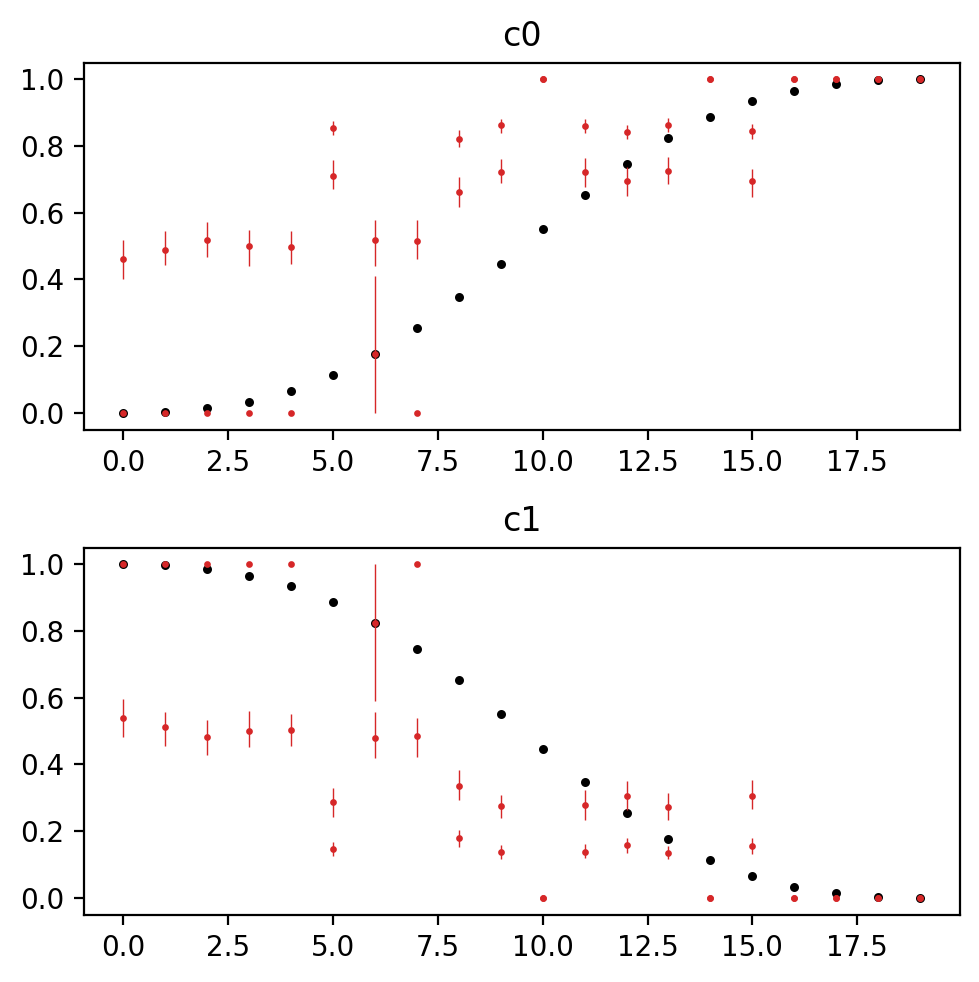

In [26]:
fig, axes = plt.subplots(nrows=sim_data.K, figsize=(5, 2.5 * sim_data.K))
for clone_i, ax in enumerate(axes.flatten()):
    clone = f"c{clone_i}"
    ax.set_title(clone)
    spot = np.arange(sim_data.S)
    ax.scatter(spot, clone_proportions[:, clone_i], c="k", s=5, zorder=5)
    H = sim_trace.posterior["H"].sel(clone=[clone])
    for chain in H.coords["chain"]:
        ax.scatter(spot, H.sel(chain=chain).mean(axis=(0)), c="tab:red", s=2, zorder=20)
        _hdi = az.hdi(H, coords={"chain": [chain]})["H"].values.squeeze()
        ax.vlines(
            x=spot, ymin=_hdi[:, 0], ymax=_hdi[:, 1], lw=0.5, zorder=10, color="tab:red"
        )

fig.tight_layout()
plt.show()

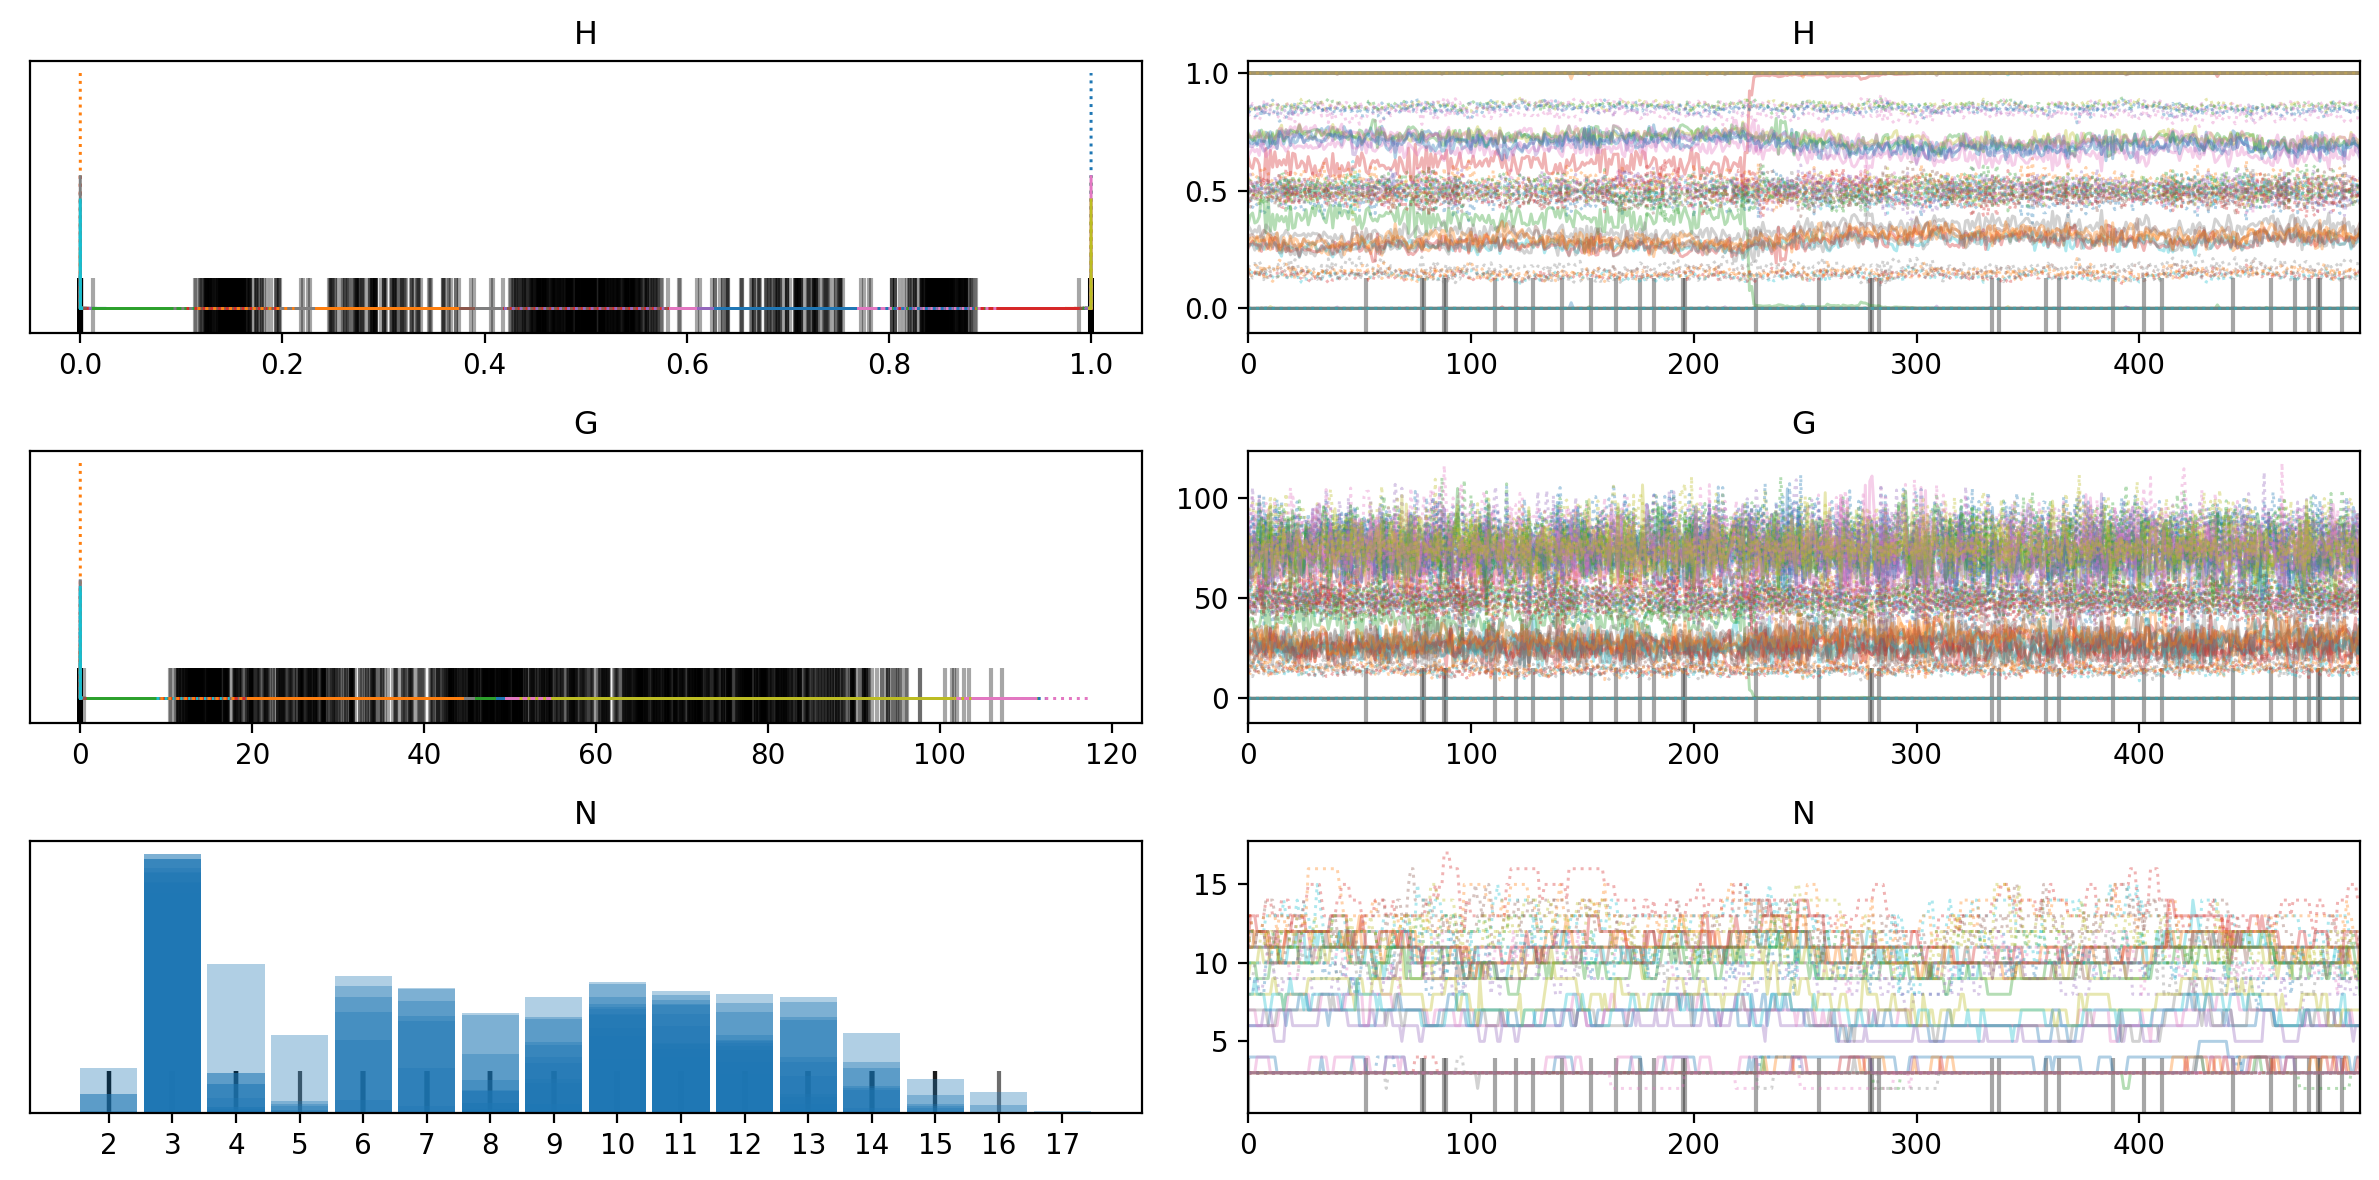

In [27]:
az.plot_trace(sim_trace, var_names=["H", "G", "N"])
plt.tight_layout()

In [28]:
az.summary(sim_trace, var_names=["N"]).assign(real_values=sim_data.Lambda)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,real_values
N[s0],3.341,0.501,3.0,4.0,0.262,0.203,4.0,4.0,1.55,4
N[s1],3.077,0.267,3.0,3.0,0.073,0.053,13.0,13.0,1.14,5
N[s2],2.969,0.210,3.0,3.0,0.031,0.022,61.0,373.0,1.06,3
N[s3],3.065,0.247,3.0,3.0,0.053,0.038,22.0,22.0,1.07,6
N[s4],3.056,0.230,3.0,3.0,0.048,0.035,23.0,23.0,1.10,5
N[s5],11.667,1.290,10.0,13.0,0.686,0.532,4.0,6.0,1.60,5
N[s6],2.990,0.403,2.0,3.0,0.143,0.107,8.0,20.0,1.18,6
N[s7],2.977,0.220,3.0,3.0,0.029,0.021,60.0,261.0,1.04,4
N[s8],10.626,1.017,9.0,12.0,0.452,0.340,5.0,19.0,1.35,2
N[s9],11.757,1.345,9.0,13.0,0.755,0.592,3.0,9.0,1.66,5


---

## Session information

In [29]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-08

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: tumoroscope

pandas    : 1.5.0
scipy     : 1.9.1
janitor   : 0.22.0
numpy     : 1.23.3
pymc      : 4.2.1
arviz     : 0.12.1
matplotlib: 3.6.0
seaborn   : 0.12.0

